# Peak detection with Seq2Seq

- Seq2seq model for peak detection
- Tensorflow/keras is used as framework.
- All data is artificial. Generating data is contained in this notebook. 

## Training model structure

<img src='model_train.png'>

input1:input sequential data

input2:label of previous point

## Encoder model for inference

<img src='encoder_model.png'>

## Decoder model for inference

<img src='decoder_model.png'>


# 1. Import

In [1]:
import pandas as pd
import numpy as np
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, Concatenate
from scipy import integrate

# 2.Constant

In [2]:
N_RNN = 200 #Number of data points 
N_IN = 1 #Number of inputs
N_OUT = 1 #Number of outputs. binary classification ⇒ 1 
N_MID = 256  # Number of neurons in LSTM layer
sample_num = 5000 # Number of 


# 3. Generate data

- 1. Baseline : Generated by sampling from a standard normal distribution.
- 2. Peak : Generated by adding noise to the Gaussian function. mu, amplitude, sigma in Gaussian function are also generated by ramdom sampling.

In [3]:
def gauss(x, a=1, mu=0, sigma=1):
    '''
    Calculate the peak curve from an array of x
     
    '''
    g = a * np.exp(-(x - mu)**2 / (2*sigma**2))
    noise = np.random.normal(loc=1, scale=0.1, size=x.shape)
    print()
    return g * noise

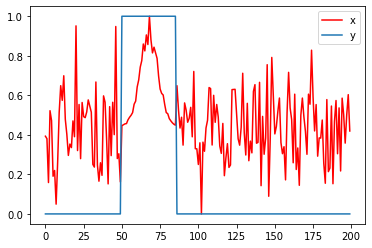

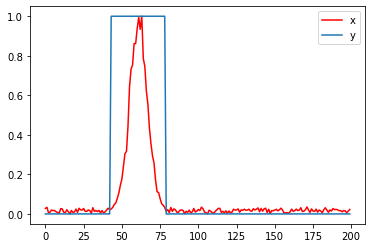

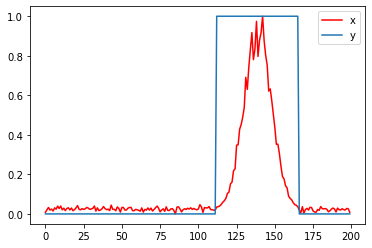

In [4]:

# Generate Data
x_encoder = np.empty((sample_num, N_RNN, 1))
y_decoder = np.zeros((sample_num, N_RNN, 1))

for i in range(sample_num):
    # generate base line 
    base_line = np.random.randn(N_RNN)*np.random.rand()
    
    # sampling of mu, sigma, a for gauusian function
    mu = int(50 + np.random.rand()*100)
    sigma = int(5 + np.random.rand()*10)
    a = 10 * np.random.rand()*10
    
    # calculate a peak curve
    peak = gauss(np.arange(-3*sigma, 3*sigma), a=a, sigma=sigma)
    base_line[mu-3*sigma:mu+3*sigma] = peak
    
    # normalization of the data
    ma = base_line.max()
    mi = base_line.min()
    base_line = (base_line - mi)/(ma - mi)
    x_encoder[i, :, :] = base_line.reshape(-1, 1)
    y_decoder[i, mu-3*sigma:mu+3*sigma, :] = 1

    # check the generated data
    if i < 3:
        plt.plot(np.arange(N_RNN), base_line, color="red", label='x')
        plt.plot(np.arange(N_RNN), y_decoder[i,:,:].flatten(), label = 'y')
        plt.legend()
        plt.show()


In [5]:
#prepare x_decoder for train model
x_decoder = np.zeros(y_decoder.shape)
x_decoder[:, 1:, :] = y_decoder[:, 0:N_RNN-1 ,:]

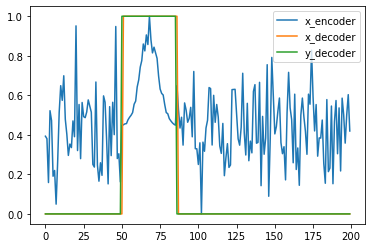

In [6]:
# check the data
plt.plot(np.arange(N_RNN), x_encoder[0,:,0].flatten(), label='x_encoder')
plt.plot(np.arange(N_RNN), x_decoder[0,:,0].flatten(), label='x_decoder')
plt.plot(np.arange(N_RNN), y_decoder[0,:,0].flatten(), label='y_decoder')
plt.legend()

# 4. Train

In [7]:
def train_model():
    # input
    encoder_input = Input(shape=(N_RNN, N_IN)) # input for encoder
    decoder_input = Input(shape=(N_RNN, N_OUT)) # input for decoder
    # encoder
    encoder_output_f, state_h_f, state_c_f = LSTM(N_MID, return_state=True)(encoder_input) 
    encoder_output_b, state_h_b, state_c_b = LSTM(N_MID, return_state=True, go_backwards=True)(encoder_input)  
    state_h = Concatenate()([state_h_f, state_h_b])
    state_c = Concatenate()([state_c_f, state_c_b])
    encoder_states = [state_h, state_c] 

    # decoder
    decoder_lstm = LSTM(N_MID*2, return_sequences=True, return_state=True)  
    decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states) 
    decoder_dense = Dense(N_OUT, activation='sigmoid')
    decoder_output = decoder_dense(decoder_output)

    model = Model([encoder_input, decoder_input], decoder_output)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    model.summary()
    #return some layers for inference
    return model, encoder_input, encoder_states, decoder_lstm, decoder_dense

In [8]:
# generate model and layers for inference
model, encoder_input, encoder_states, decoder_lstm, decoder_dense = train_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        264192      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 256),        264192      ['input_1[0][0]']                
                                 (None, 256),                                                 

In [9]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Epoch 1/20
278/278 [==============================] - 26s 73ms/step - loss: 0.1487
Epoch 2/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0593
Epoch 3/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0478
Epoch 4/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0458
Epoch 5/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0812
Epoch 6/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0468
Epoch 7/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0458
Epoch 8/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0453
Epoch 9/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0452
Epoch 10/20
278/278 [==============================] - 20s 72ms/step - loss: 0.0453
Epoch 11/20
278/278 [==============================] - 20s 73ms/step - loss: 0.0449
Epoch 12/20
278/278 [==============================] - 21s 74ms/step - loss: 0.0445
E

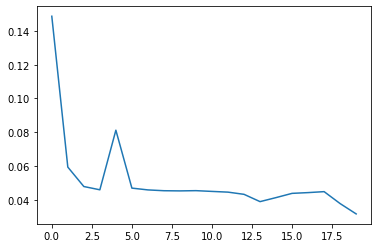

In [10]:
#Training
history = model.fit([x_encoder, x_decoder], y_decoder, batch_size=18, epochs=20)

loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

# 5. Prediction

In [11]:
def predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense):
    # encoder model
    encoder_model = Model(encoder_input, encoder_states)

    # decoder model
    decoder_input = Input(shape=(1, N_OUT)) # (1, 1)

    decoder_state_in = [Input(shape=(N_MID*2,)), Input(shape=(N_MID*2,))]
    decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input, initial_state=decoder_state_in) # Using Trained LSTM
    decoder_states = [decoder_state_h, decoder_state_c]

    decoder_output = decoder_dense(decoder_output) # Using Trained Dense layer
    decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_states) 

    return encoder_model, decoder_model

# generate inference model
encoder_model, decoder_model = predict_model(encoder_input, encoder_states, decoder_lstm, decoder_dense)

In [12]:
# predict function
def predict(x_test, encoder_model, decoder_model):
    #calculate hidden state of LSTM by the Encoder
    state_value = encoder_model.predict(x_test)  
    y_decoder = np.zeros((1, 1, 1)) 
    predicted = [] # result
    #calculate output by step
    for i in range(N_RNN):
        y, h, c = decoder_model.predict([y_decoder] + state_value)  # previous output and state are input for next step
        y = y[0,0,0]
        predicted.append(y)
        y_decoder[0,0,0] = y  # output for next step input
        state_value = [h, c] # state for next step

    return predicted

In [13]:
keras.utils.plot_model(decoder_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
# check the prediction with training data
all_preds = []
for x_test in x_encoder[:5]:
    y_pred = predict(x_test.reshape(-1, N_RNN, 1), encoder_model, decoder_model)
    all_preds.append((np.array(y_pred) > 0.5).astype(int))

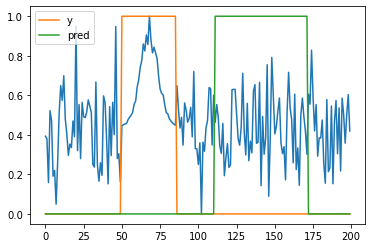

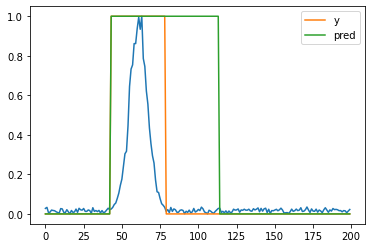

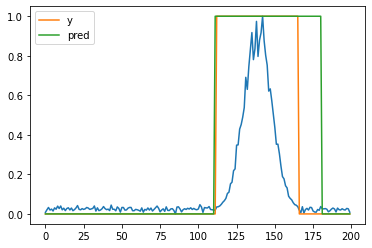

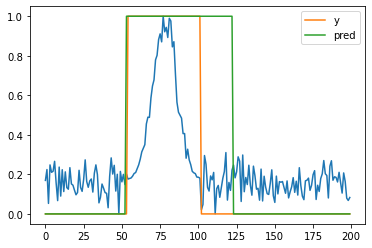

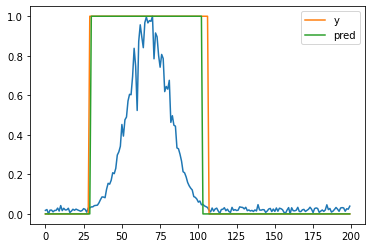

In [15]:
#show prediction result
for x, y, pred in zip(x_encoder[:5], y_decoder[:5], all_preds):
    x = x.ravel()
    y = y.ravel()
    plt.figure()
    plt.plot(np.arange(N_RNN), x)
    plt.plot(np.arange(N_RNN), y, label='y')
    plt.plot(np.arange(N_RNN), pred, label='pred')
    plt.legend()
    plt.show()

# 6. Test

Length of the input must be same as the train data.

The shortage was filled with zero.

In [16]:
# generate test data 
test_sample = 3
x_test_encoder = np.empty((test_sample, N_RNN, 1))
y_test_decoder = np.zeros((test_sample, N_RNN, 1))

for i in range(test_sample):
    base_line = np.random.randn(N_RNN)*np.random.rand()
    mu = int(50 + np.random.rand()*100)
    sigma = int(5 + np.random.rand()*10)
    a = 10 * np.random.rand()*10
    peak = gauss(np.arange(-3*sigma, 3*sigma), a=a, sigma=sigma)
    base_line[mu-3*sigma:mu+3*sigma] = peak
    ma = base_line.max()
    mi = base_line.min()
    base_line = (base_line - mi)/(ma - mi)
    x_test_encoder[i, :, :] = base_line.reshape(-1, 1)
    y_test_decoder[i, mu-3*sigma:mu+3*sigma, :] = 1

In [17]:
#prediction
all_preds_test = []
for x_test in x_test_encoder:
    y_pred = predict(x_test.reshape(-1, N_RNN, 1), encoder_model, decoder_model)
    all_preds_test.append((np.array(y_pred) > 0.5).astype(int))

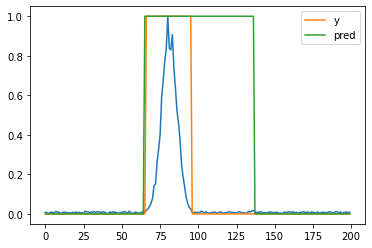

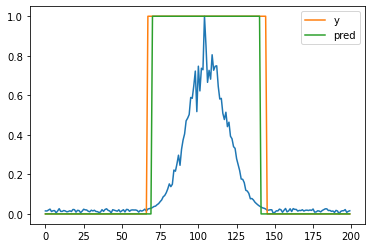

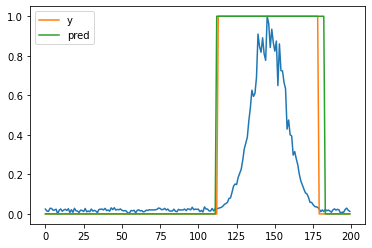

In [18]:
#show prediction result
for x, y, pred in zip(x_test_encoder, y_test_decoder, all_preds_test):
    x = x.ravel()
    y = y.ravel()
    plt.figure()
    plt.plot(np.arange(N_RNN), x)
    plt.plot(np.arange(N_RNN), y, label='y')
    plt.plot(np.arange(N_RNN), pred, label='pred')
    plt.legend()
    plt.show()